In [1]:
import scipy.io
import scipy.signal as signal
from scipy.signal import butter, lfilter
import numpy as np
import pandas as pd
import mne
from mne.preprocessing import ICA
from mne.channels import make_standard_montage
%matplotlib qt
%gui qt
from time import time
from matplotlib import pyplot as plt
from mne.preprocessing import find_eog_events, regress_artifact
from mne.datasets import sample
from mne.viz import plot_raw
from mne.preprocessing import corrmap
from mne.viz import plot_raw
from meegkit.asr import ASR
from meegkit.utils.matrix import sliding_window
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def apply_asr(raw, sfreq=250, cutoff=2.5, blocksize=100, win_len=0.5,
        win_overlap=0.66, max_dropout_fraction=0.1,
        min_clean_fraction=0.25, name='asrfilter', method='euclid',
        estimator='scm'):
   
    h, w = raw.shape
    
    # t = int(raw.shape[1] / sfreq)
    asr = ASR(sfreq=sfreq, cutoff=cutoff, blocksize=blocksize, win_len=win_len,
        win_overlap=win_overlap, max_dropout_fraction=max_dropout_fraction,
        min_clean_fraction=min_clean_fraction, name=name, method=method,
        estimator=estimator)
        
        # method='euclid'
    # train_idx = np.arange(0 * sfreq, t * sfreq, dtype=int)
    _, sample_mask = asr.fit(raw)
    
    # Apply filter using sliding (non-overlapping) windows
    X = sliding_window(raw, window=int(sfreq), step=int(sfreq))
    Y = np.zeros_like(X)
    for i in range(X.shape[1]):
        Y[:, i, :] = asr.transform(X[:, i, :])
    
    raw = X.reshape(h, -1)  # reshape to (n_chans, n_times)
    clean = Y.reshape(h, -1)
    return raw, clean

import pyedflib

In [22]:
###CLEAN .TXT DATASETS###

hh=np.array([1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,28,29,30,31,
                      32,35,36,37,38,39,40,41,42,43])
for i in range(len(hh)):
    data=np.loadtxt('subject_'+str(hh[i])+'.txt')
    filter_signal= butter_bandpass_filter(data, 4, 49, 250)
    signal3, filter_asr_signal3 = apply_asr(filter_signal.T, sfreq=250)
    np.save('subject'+str(hh[i])+'_clean.npy', filter_asr_signal3)

<ipython-input-2-6c1de836ff1c>:34: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[:, i, :] = asr.transform(X[:, i, :])


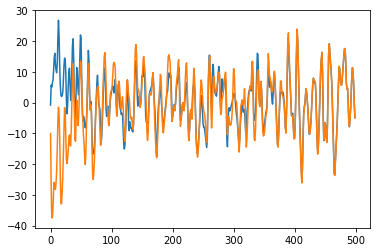

In [18]:
###PLOT AND COMPARE CLEAN AND NOISY DATASETS###


import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
plt.plot(range(0,500,1),filter_asr_signal3[3,0:500], filter_signal[0:500,3].T)
plt.show()

In [30]:
###CLEAN .MAT DATASETS###

hm=np.array([3,26,27,33,34])
for i in range(len(hm)):
    data = scipy.io.loadmat('subject_'+str(hm[i])+'.mat')
    f=data['EEG_Data']
    g=np.array((f))
    filter_signal= butter_bandpass_filter(g, 4, 49, 250)
    signal3, filter_asr_signal3 = apply_asr(filter_signal, sfreq=250)
    np.save('subject'+str(hm[i])+'_clean.npy', filter_asr_signal3)
#from tempfile import TemporaryFile
#pre_khanzade = TemporaryFile()

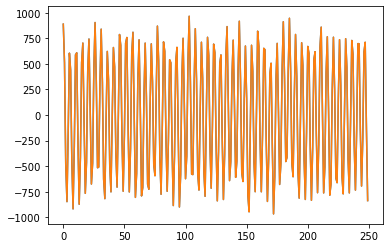

In [47]:
###PLOT AND COMPARE CLEAN AND NOISY DATASETS###


import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
plt.plot(range(0,250,1),filter_signal[15,20000:20250],filter_asr_signal3[15,20000:20250])
plt.show()